In [25]:
import numpy as np
import h5py
import os
import pandas as pd
import matplotlib.pyplot as plt

Load the AMS02 .dat files and compare with test.h5; want to prepare a test.dat to use for HMC sampling

## Functions and constants

In [26]:
# Hardcoded model choices.
INPUTS = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
# These are hardcoded for transforms. Used in both parities.
X_MIN = np.array([0.,  2.5, 100., 0.4, 0.4, 0.4, 0.4, 400.]) 
X_MAX = np.array([85., 9.5, 870., 1.7, 1.7, 2.3, 2.3, 700.])
X_RANGE = np.array([ 85., 7., 770., 1.3000001, 1.3000001, 1.9, 1.9, 300.])
# X_MIN,X_MAX,X_RANGE = get_minmax_params(get_attributes(infile))
# These are selected from above and hardcoded.
PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 
# These parameter don't include (alpha, cmf, vspoles) which we specify separately.
PARAMETERS_SPECIFIED = ['alpha', 'cmf', 'vspoles']
PARAMETERS_SPECIFIED_MIN = np.array([0.,  2.5, 400.])
PARAMETERS_SPECIFIED_MAX = np.array([85., 9.5, 700.])
# Calculated from positive file, used for both.
Y_LOG_MAX = 8.815241

NN_SPLIT_SEED = 36 # Random seed for splitting data into train/test sets for reproducibiity. Buffer size must be the same as num_samples.

# Now there are only 32 rigidity values.
# filename = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed.h5'
# with h5py.File(filename,'r') as f:
#     RIGIDITY_VALS = f['/info/rigidity'][:]
RIGIDITY_VALS = np.array(
      [  0.2       ,   0.20217378,   0.20659248,   0.21340226,
         0.22525435,   0.24034894,   0.25924241,   0.28573246,
         0.31835225,   0.35855115,   0.41265203,   0.48007787,
         0.56459135,   0.67849465,   0.82423959,   1.0121744 ,
         1.27012627,   1.61114001,   2.06592477,   2.70698217,
         3.54695997,   4.80077869,   6.49781115,   8.98694648,
        12.70126265,  17.95071033,  25.92424111,  37.84646324,
        56.45913512,  85.14084907, 129.78860616, 200.])

In [27]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df


def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

def _get_transform_params(X):
    """
    Helper function for calculating min max.
    """
    assert len(PARAMETERS) != len(PARAMETERS_SPECIFIED)
    input_dim = X.ndim
    if (X.ndim == 1 and len(X) == len(INPUTS)) or (X.ndim == 2 and X.shape[1] == len(INPUTS)):
        # Full set of inputs. 
        MIN, MAX = X_MIN, X_MAX
    elif ((X.ndim == 1 and len(X) == len(PARAMETERS)) or (X.ndim == 2 and X.shape[1] == len(PARAMETERS))):
        # Assume specified parameters have already been specified separately.
        MIN, MAX = PARAMETERS_MIN, PARAMETERS_MAX
    elif ((X.ndim == 1 and len(X) == len(PARAMETERS_SPECIFIED)) or (X.ndim == 2 and X.shape[1] == len(PARAMETERS_SPECIFIED))):
        # Assume other parameters have already been specified separately.
        MIN, MAX = PARAMETERS_SPECIFIED_MIN, PARAMETERS_SPECIFIED_MAX
    else:
        raise Exception
    return (MIN, MAX)
    

def transform_input(X):
    '''
    Parameters from HMC are all in min-max scaled space.
    This function tries to smartly handle case where some of the inputs are specified separately.
    '''
    MIN, MAX = _get_transform_params(X)
    RANGE = MAX - MIN
    rval = (X - MIN) / RANGE
    return rval


def untransform_input(X):
    '''
    Parameters from HMC are all in min-max scaled space.
    This function tries to smartly handle case where some of the inputs are specified separately.
    '''
    MIN, MAX = _get_transform_params(X)
    RANGE = MAX - MIN
    rval = X * RANGE + MIN
    return rval

def load_data_ams(filename, integrate=False):
    """ Load AMS data from Claudio. Each file contains measurements over a certain time interval. 
    Args:
        filename = Filename of observations.
                   Original dataset was '../data/BR2461.dat'
                   New datasets are in '../data/oct2022/'
                   New yearly datasets are in '../data/2024/yearly'
        integrate = If True, integrate over bin regions, so return r1, r2
                Otherwise, interpolate flux at the geoemtric mean of the bin and return bin_midpoints
    """
    dataset_ams = np.loadtxt(filename, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error, dataset (only if yearly dataset)
    r1, r2 = dataset_ams[:,0], dataset_ams[:,1]

    if 'yearly' in filename:
        # Need to sort yearly datasets by r1
        sort_indices = np.argsort(r1)
        dataset_ams = dataset_ams[sort_indices, :]
        r1, r2 = dataset_ams[:,0], dataset_ams[:,1]

    bins = np.concatenate([r1[:], r2[-1:]])
    observed = dataset_ams[:,2]   # Observed Flux
    uncertainty = dataset_ams[:,3]
    assert len(bins) == len(observed)+1

    # bin_midpoints = (r1 + r2)/2  # Arithmetic mean
    bin_midpoints = (r1 * r2) ** 0.5  # Geometric mean seemed to work better in exp.

    if integrate:
        return bins, zip(r1, r2), observed, uncertainty
    else:
        return bins, bin_midpoints, observed, uncertainty

def load_dataset(polarity):
    # 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
    # features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
    data_path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025'
    test_file = f'{data_path}/{polarity}/test.h5'

    # Load test data
    with h5py.File(test_file, 'r') as h5:
        num_test_samples, num_inputs,  = h5['X_minmax'].shape
        _, num_flux,  = h5['Y_log_scaled'].shape
    x_test = h5py.File(test_file, 'r')['X_minmax'][:].reshape(num_test_samples, num_inputs)
    y_test = h5py.File(test_file, 'r')['Y_log_scaled'][:].reshape(num_test_samples, num_flux)   

Check .dat file

In [28]:
dat_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/GalacticCosmicRays/data/oct2022/AMS02_H-PRL2018/AMS02_H-PRL2018_20110611-20110707.dat'
dataset_ams = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
print(dataset_ams[:1])

[[  1.        1.16    898.1      43.24591]]


## Analyze PAMELA and AMS02 H data

---
AMS-02 Mean and Std Dev of Flux Errors over all Intervals:


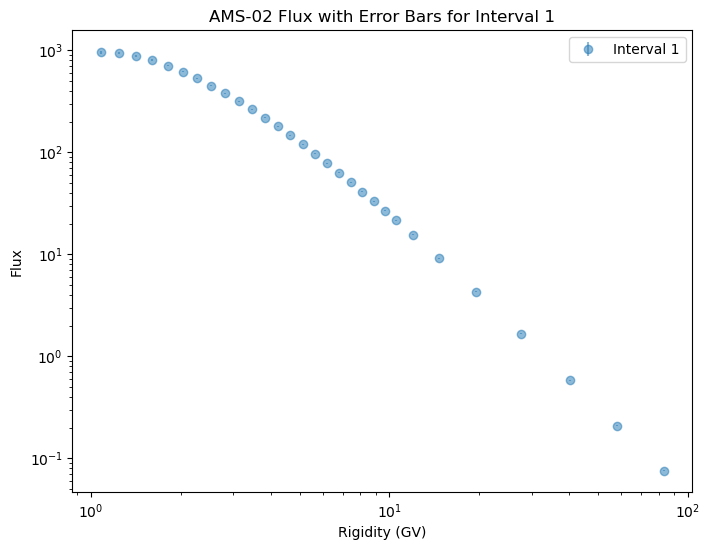

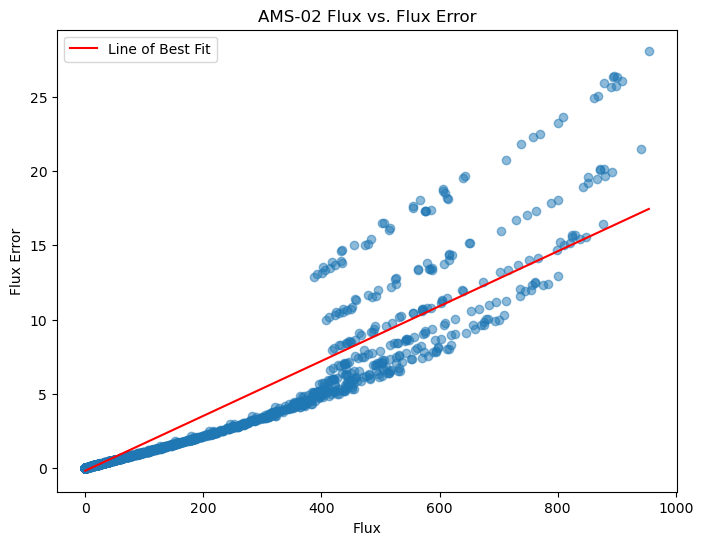

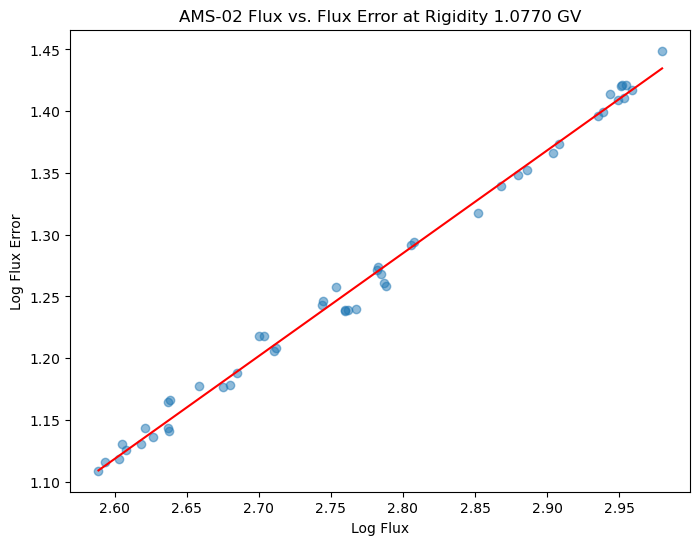

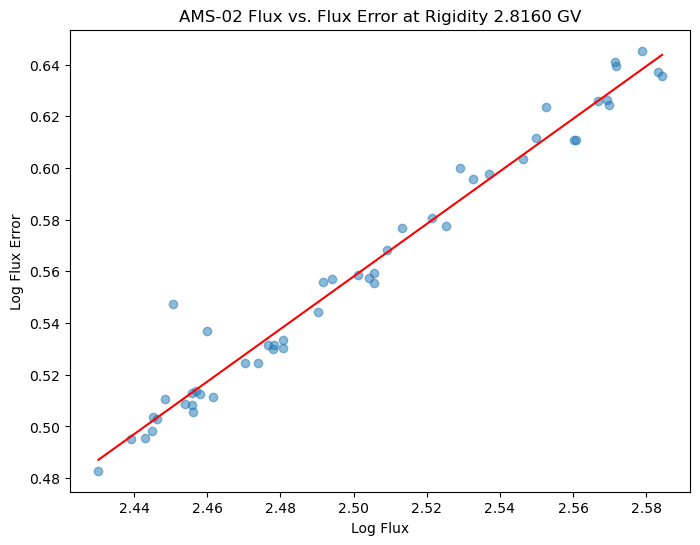

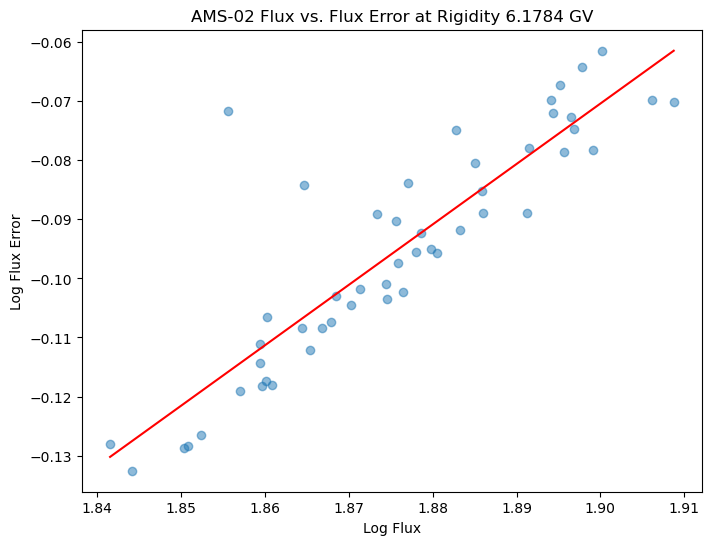

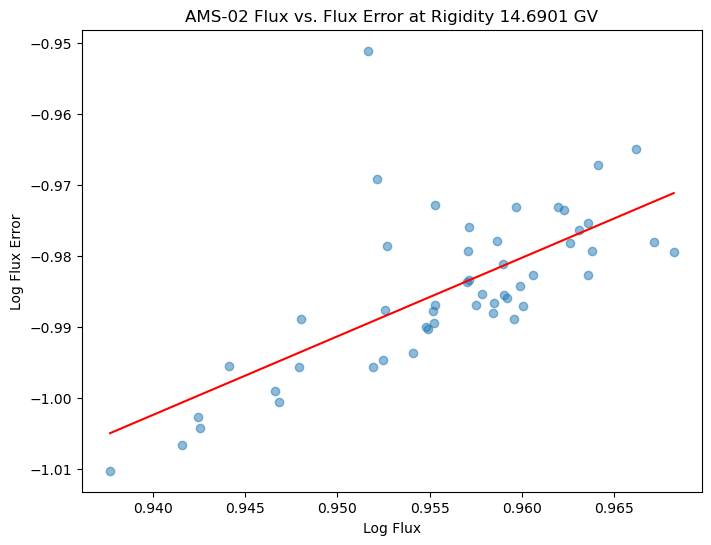

{0: poly1d([ 0.83303395, -1.04752911]), 1: poly1d([ 0.89357604, -1.33429013]), 2: poly1d([ 0.95844734, -1.60976335]), 3: poly1d([ 1.00120654, -1.79832886]), 4: poly1d([ 1.01644498, -1.88801482]), 5: poly1d([ 1.01859748, -1.92867975]), 6: poly1d([ 1.01856118, -1.9532927 ]), 7: poly1d([ 1.01782445, -1.97237736]), 8: poly1d([ 1.01682839, -1.98406249]), 9: poly1d([ 1.02099514, -2.005904  ]), 10: poly1d([ 1.01657421, -2.00256327]), 11: poly1d([ 1.01741153, -2.00738704]), 12: poly1d([ 1.02600219, -2.02760186]), 13: poly1d([ 1.0368616 , -2.05264229]), 14: poly1d([ 1.07480761, -2.12868104]), 15: poly1d([ 1.01157408, -1.99750612]), 16: poly1d([ 1.02312486, -2.01433427]), 17: poly1d([ 1.02540897, -2.01604202]), 18: poly1d([ 1.03473935, -2.02819725]), 19: poly1d([ 1.04092426, -2.03009213]), 20: poly1d([ 1.04754461, -2.03170005]), 21: poly1d([ 1.04312308, -2.02160294]), 22: poly1d([ 1.06196322, -2.04033498]), 23: poly1d([ 1.0244399, -1.9793887]), 24: poly1d([ 1.10880736, -2.04469595]), 25: poly1d(

In [29]:
# Load all 132 files, for each rigidity calculate mean and average of the flux error (column 3)
df = index_mcmc_runs(file_version='2023')
path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/GalacticCosmicRays/data/oct2022/'

for idx in range(50): # AMS-02 has the first 50 intervals.
    df_int = df.iloc[idx:idx+1].copy(deep=True)
    interval = df_int.interval.iloc[0]
    polarity = df_int.polarity.iloc[0]
    exp_name = df_int.experiment_name.iloc[0]

    dat_file = f"{path}/{exp_name}/{exp_name}_{interval}.dat"
    dataset_ams = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
    if idx == 0:
        ams_fluxes = np.zeros((len(df), len(dataset_ams)))
        ams_errors = np.zeros((len(df), len(dataset_ams)))
        ams_rigidity_vals = (dataset_ams[:,0] * dataset_ams[:,1]) ** 0.5  # Geometric mean
    ams_fluxes[idx,:] = dataset_ams[:,2]
    ams_errors[idx,:] = dataset_ams[:,3]

ams_mean_errors = np.mean(ams_errors, axis=0)
ams_std_errors = np.std(ams_errors, axis=0)
print("---\nAMS-02 Mean and Std Dev of Flux Errors over all Intervals:")
# for r, mean_err, std_err in zip(ams_rigidity_vals, ams_mean_errors, ams_std_errors):
#     print(f"Rigidity: {r:.4f} GV, Mean Error: {mean_err:.6e}, Std Error: {std_err:.6e}")

# Plot flux against error for AMS-02
plt.figure(figsize=(8,6))
plt.errorbar(ams_rigidity_vals, ams_fluxes[0,:], yerr=ams_errors[0,:], fmt='o', label='Interval 1', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rigidity (GV)')
plt.ylabel('Flux')
plt.title('AMS-02 Flux with Error Bars for Interval 1')
plt.legend()
plt.show()

# Plot flux against error for AMS-02
plt.figure(figsize=(8,6))
plt.scatter(ams_fluxes, ams_errors, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# Line of best fit
coeffs = np.polyfit(ams_fluxes.flatten(), ams_errors.flatten(), deg=1)
poly_ams = np.poly1d(coeffs)
x_vals = np.linspace(np.min(ams_fluxes), np.max(ams_fluxes), 32)
y_vals = poly_ams(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Line of Best Fit')

plt.xlabel('Flux')
plt.ylabel('Flux Error')
plt.title('AMS-02 Flux vs. Flux Error')
plt.legend()
plt.show()

# For each rigidity value, plot flux vs. error for all intervals at that rigidity
ams_rigidity_poly1d = {}
for rig_idx in range(len(ams_rigidity_vals)):
    # Remove inidices where flux and error are 0
    log_ams_fluxes = np.log10(ams_fluxes[:,rig_idx][ams_fluxes[:,rig_idx] > 0])
    log_ams_errors = np.log10(ams_errors[:,rig_idx][ams_errors[:,rig_idx] > 0])

    # Line of best fit
    coeffs = np.polyfit(log_ams_fluxes, log_ams_errors, deg=1)
    poly_ams = np.poly1d(coeffs)
    ams_rigidity_poly1d[rig_idx] = poly_ams

    if rig_idx % 8 == 0:
        x_vals = np.linspace(np.min(log_ams_fluxes), np.max(log_ams_fluxes), 32)
        y_vals = poly_ams(x_vals)

        plt.figure(figsize=(8,6))
        plt.scatter(log_ams_fluxes, log_ams_errors, alpha=0.5)
        plt.xlabel('Log Flux')
        plt.ylabel('Log Flux Error')
        plt.title(f'AMS-02 Flux vs. Flux Error at Rigidity {ams_rigidity_vals[rig_idx]:.4f} GV')
        plt.plot(x_vals, y_vals, color='red', label='Line of Best Fit')
        plt.show()
        plt.close()

print(ams_rigidity_poly1d)

---
PAMELA Mean and Std Dev of Flux Errors over all Intervals:
Rigidity: 0.4147 GV, Mean Error: 4.479121e+01, Std Error: 2.347838e+01
Rigidity: 0.4447 GV, Mean Error: 5.054721e+01, Std Error: 2.558942e+01
Rigidity: 0.4650 GV, Mean Error: 5.797366e+01, Std Error: 2.725209e+01
Rigidity: 0.4799 GV, Mean Error: 5.738425e+01, Std Error: 3.156812e+01
Rigidity: 0.4999 GV, Mean Error: 5.980590e+01, Std Error: 3.236475e+01
Rigidity: 0.5296 GV, Mean Error: 6.282839e+01, Std Error: 3.496509e+01
Rigidity: 0.5599 GV, Mean Error: 7.075073e+01, Std Error: 3.687140e+01
Rigidity: 0.5799 GV, Mean Error: 7.372689e+01, Std Error: 3.743913e+01
Rigidity: 0.6097 GV, Mean Error: 7.454204e+01, Std Error: 4.016703e+01
Rigidity: 0.6448 GV, Mean Error: 7.909227e+01, Std Error: 4.248430e+01
Rigidity: 0.6699 GV, Mean Error: 8.175383e+01, Std Error: 4.329927e+01
Rigidity: 0.6948 GV, Mean Error: 8.288570e+01, Std Error: 4.549683e+01
Rigidity: 0.7297 GV, Mean Error: 8.779894e+01, Std Error: 4.818664e+01
Rigidity: 0.76

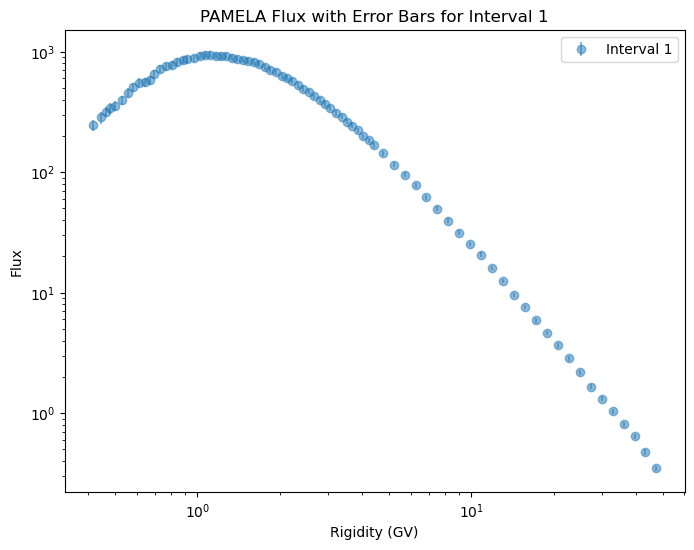

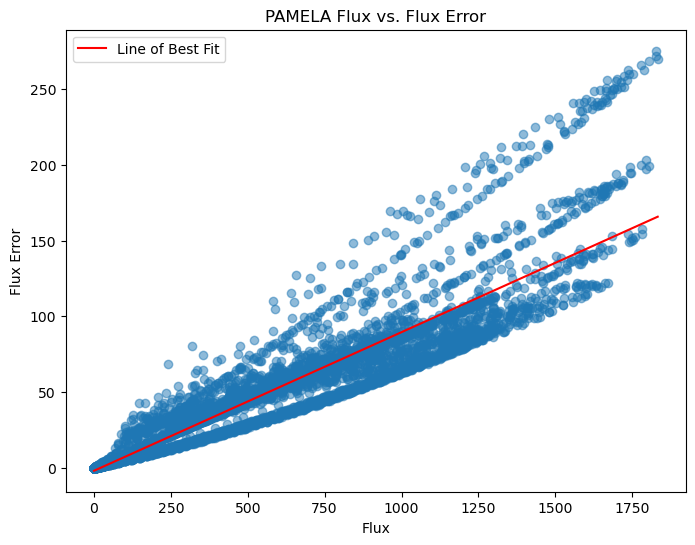

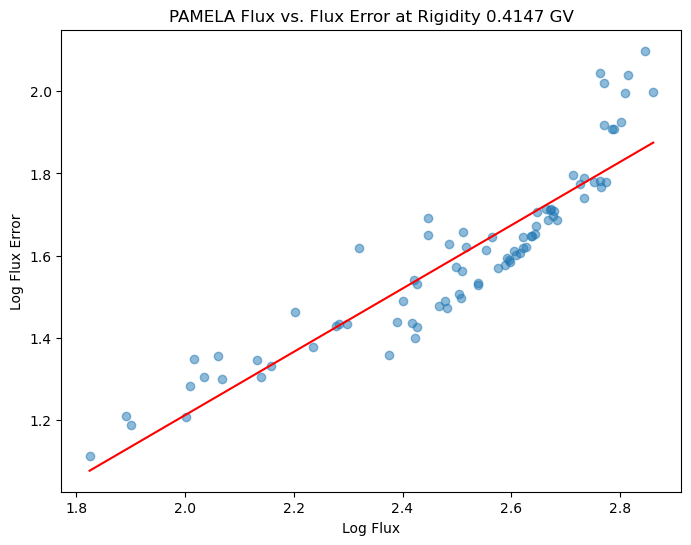

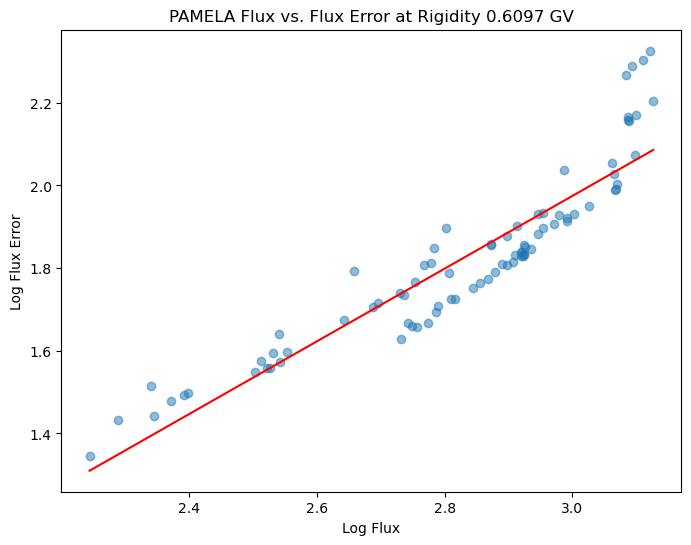

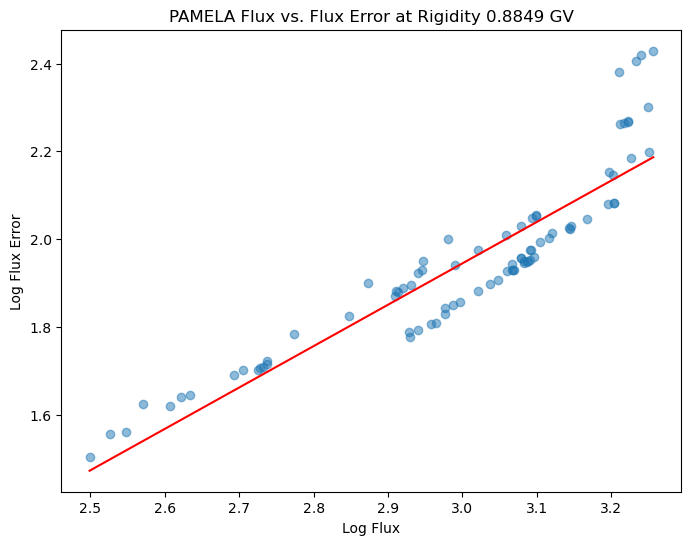

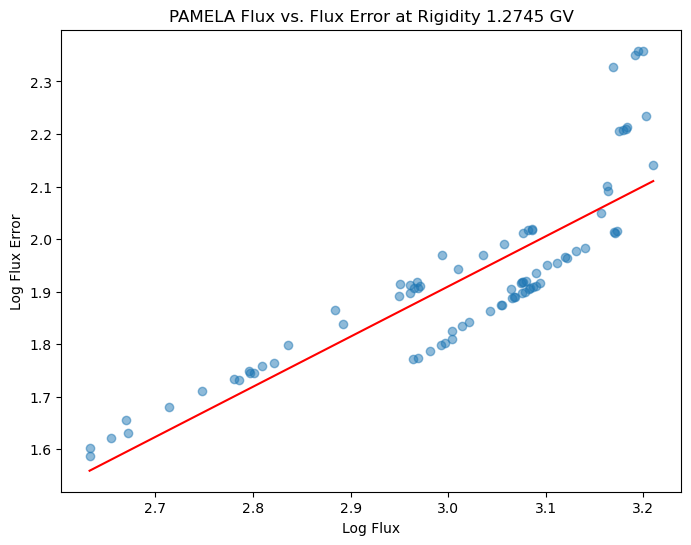

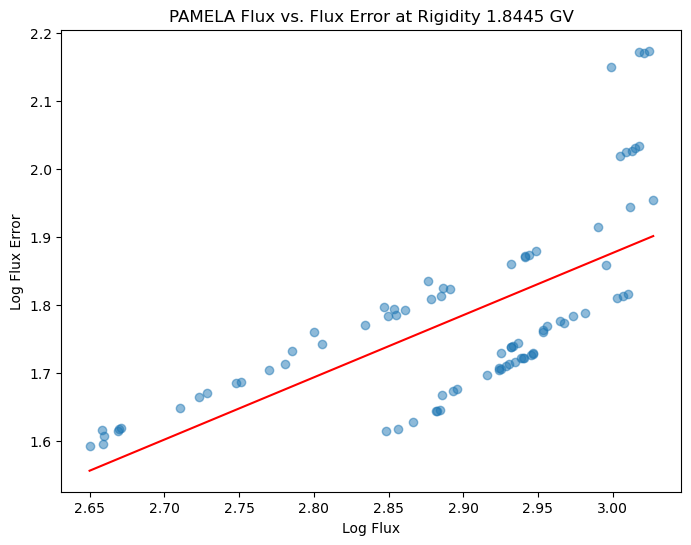

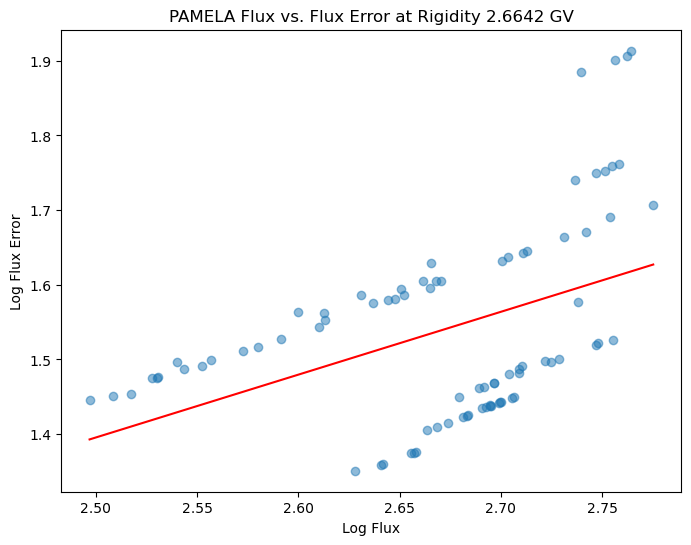

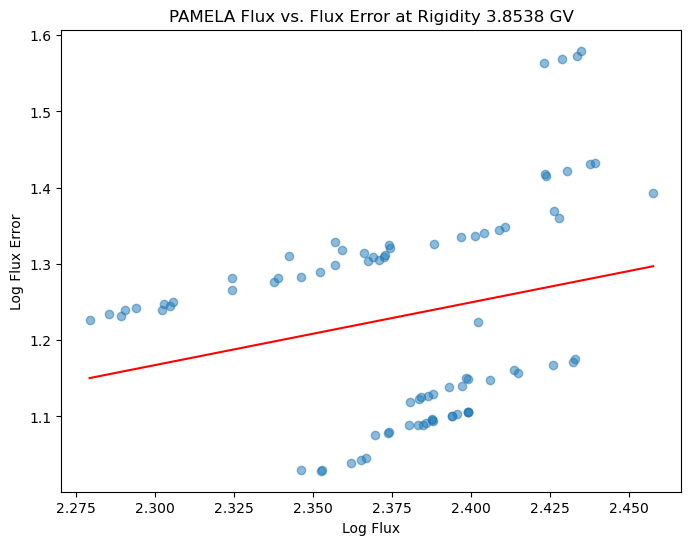

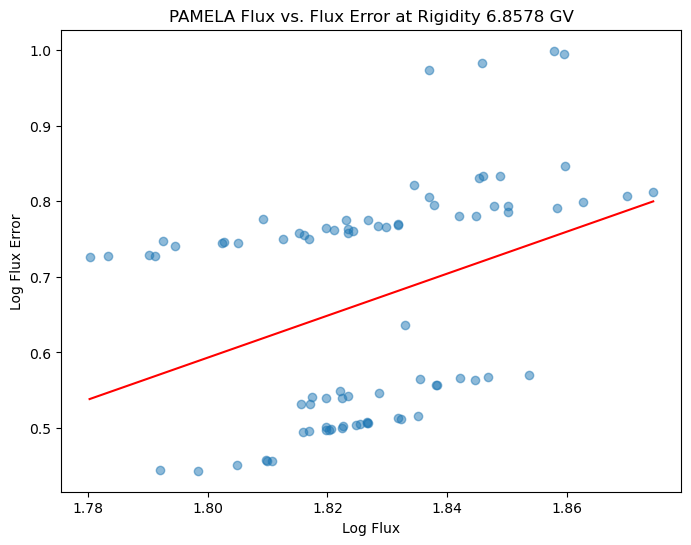

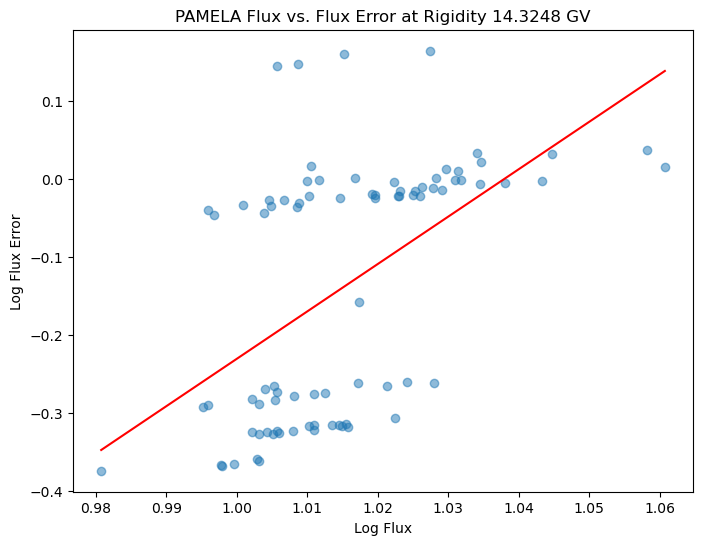

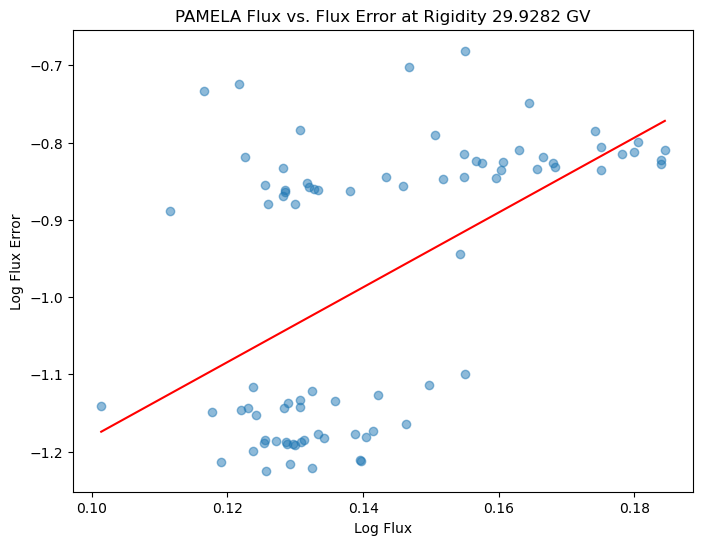

{0: poly1d([ 0.76999852, -0.32792614]), 1: poly1d([ 0.72429365, -0.19473755]), 2: poly1d([0.5624658 , 0.26289113]), 3: poly1d([ 0.73206542, -0.21871797]), 4: poly1d([ 0.7491693 , -0.27743717]), 5: poly1d([ 0.87753123, -0.64832675]), 6: poly1d([ 0.7505187, -0.2698938]), 7: poly1d([ 0.75359355, -0.27979397]), 8: poly1d([ 0.8800098 , -0.66537638]), 9: poly1d([ 0.88206363, -0.67397335]), 10: poly1d([ 0.85538738, -0.59483916]), 11: poly1d([ 0.9477263 , -0.88384703]), 12: poly1d([ 0.94830295, -0.8885507 ]), 13: poly1d([ 0.98805576, -1.01721781]), 14: poly1d([ 0.94905722, -0.89699069]), 15: poly1d([ 0.98042423, -1.00101376]), 16: poly1d([ 0.94264971, -0.88294242]), 17: poly1d([ 0.97206232, -0.98127583]), 18: poly1d([ 0.98668384, -1.03244963]), 19: poly1d([ 0.9573228 , -0.94190542]), 20: poly1d([ 0.98036385, -1.0183833 ]), 21: poly1d([ 0.97336526, -0.99970318]), 22: poly1d([ 0.96593612, -0.9795156 ]), 23: poly1d([ 0.95020156, -0.93518182]), 24: poly1d([ 0.95490364, -0.95473685]), 25: poly1d([ 

In [30]:
for idx in range(50, 133): # PAMELA is intervals 50-132.
    df_int = df.iloc[idx:idx+1].copy(deep=True)
    interval = df_int.interval.iloc[0]
    polarity = df_int.polarity.iloc[0]
    exp_name = df_int.experiment_name.iloc[0]

    dat_file = f"{path}/{exp_name}/{exp_name}_{interval}.dat"
    dataset_pamela = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
    if idx == 50:
        pamela_fluxes = np.zeros((len(df)-50, len(dataset_pamela)))
        pamela_errors = np.zeros((len(df)-50, len(dataset_pamela)))
        pamela_rigidity_vals = (dataset_pamela[:,0] * dataset_pamela[:,1]) ** 0.5  # Geometric mean
    pamela_fluxes[idx-50,:] = dataset_pamela[:,2]
    pamela_errors[idx-50,:] = dataset_pamela[:,3]
    
pamela_mean_errors = np.mean(pamela_errors, axis=0)
pamela_std_errors = np.std(pamela_errors, axis=0)
print("---\nPAMELA Mean and Std Dev of Flux Errors over all Intervals:")
for r, mean_err, std_err in zip(pamela_rigidity_vals, pamela_mean_errors, pamela_std_errors):
    print(f"Rigidity: {r:.4f} GV, Mean Error: {mean_err:.6e}, Std Error: {std_err:.6e}")

# Plot flux against error for PAMELA
plt.figure(figsize=(8,6))
plt.errorbar(pamela_rigidity_vals, pamela_fluxes[0,:], yerr=pamela_errors[0,:], fmt='o', label='Interval 1', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rigidity (GV)')
plt.ylabel('Flux')
plt.title('PAMELA Flux with Error Bars for Interval 1')
plt.legend()
plt.show()

# Plot flux against error for PAMELA
plt.figure(figsize=(8,6))
plt.scatter(pamela_fluxes, pamela_errors, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# Line of best fit
coeffs = np.polyfit(pamela_fluxes.flatten(), pamela_errors.flatten(), deg=1)
poly_pamela = np.poly1d(coeffs)
x_vals = np.linspace(np.min(pamela_fluxes), np.max(pamela_fluxes), 32)
y_vals = poly_pamela(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Line of Best Fit')

plt.xlabel('Flux')
plt.ylabel('Flux Error')
plt.title('PAMELA Flux vs. Flux Error')
plt.legend()
plt.show()

# For each rigidity value, plot flux vs. error for all intervals at that rigidity
pamela_rigidity_poly1d = {}
for rig_idx in range(len(pamela_rigidity_vals)):
    # Remove inidices where flux and error are 0
    log_pamela_fluxes = np.log10(pamela_fluxes[:,rig_idx][pamela_fluxes[:,rig_idx] > 0])
    log_pamela_errors = np.log10(pamela_errors[:,rig_idx][pamela_errors[:,rig_idx] > 0])

    # Line of best fit
    coeffs = np.polyfit(log_pamela_fluxes, log_pamela_errors, deg=1)
    poly_pamela = np.poly1d(coeffs)
    pamela_rigidity_poly1d[rig_idx] = poly_pamela

    if rig_idx % 8 == 0:
        x_vals = np.linspace(np.min(log_pamela_fluxes), np.max(log_pamela_fluxes), 32)
        y_vals = poly_pamela(x_vals)

        plt.figure(figsize=(8,6))
        plt.scatter(log_pamela_fluxes, log_pamela_errors, alpha=0.5)
        plt.xlabel('Log Flux')
        plt.ylabel('Log Flux Error')
        plt.title(f'PAMELA Flux vs. Flux Error at Rigidity {pamela_rigidity_vals[rig_idx]:.4f} GV')
        plt.plot(x_vals, y_vals, color='red', label='Line of Best Fit')
        plt.show()
        plt.close()

print(pamela_rigidity_poly1d)

## Get test data

In [40]:
# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
h5_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/test.h5'

# Load test data
with h5py.File(h5_file, 'r') as h5:
    num_test_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
x_test = h5py.File(h5_file, 'r')['X_minmax'][:].reshape(num_test_samples, num_inputs)
y_test = h5py.File(h5_file, 'r')['Y_log_scaled'][:].reshape(num_test_samples, num_flux)

# print columns in h5py.File(h5_file, 'r')
print(h5py.File('/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/2023_07_01/neg/model_collection_1AU_90deg_0deg_fixed_full.h5', 'r')['model'].keys())

# get alpha, cmf, and vspoles (0, 1, and 7 index)
specified_parameters = x_test[:, [0, 1, 7]]

print(f'specified_parameters shape: {specified_parameters.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
print('---')
print(f'First 10 samples of specified_parameters_unscaled:\n{specified_parameters[:10]}\n')
print(f'First 10 samples of x_test:\n{x_test[:10]}\n')
print(f'First 10 samples of y_test:\n{y_test[:10]}')
print('---')

# Undo scaling and log transforms
# Calculated from positive file, used for both.
Y_LOG_MAX = 8.815241
y_test = y_test * Y_LOG_MAX # Undo max scaling.
y_test = np.exp(y_test) # Undo log transform of target output.

specified_parameters_unscaled = untransform_input(specified_parameters)
x_test_unscaled = untransform_input(x_test)

print(f'specified_parameters_unscaled shape: {specified_parameters_unscaled.shape}, y_test shape: {y_test.shape}')
print('---')
print(f'First 10 samples of specified_parameters_unscaled:\n{specified_parameters_unscaled[:10]}\n')
print(f'First 10 samples of x_test_unscaled sampled params: \n{x_test_unscaled[:, [2, 3, 4, 5, 6]][:10]}\n')
print(f'First 10 samples of x_test_unscaled:\n{x_test_unscaled[:10]}\n')
print(f'First 10 samples of y_test_unscaled:\n{y_test[:10]}')
print('---')

<KeysViewHDF5 ['alpha', 'cmf', 'cpa', 'flux', 'imodel', 'ipar', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'quality', 'vseq', 'vspoles']>
specified_parameters shape: (198766, 3), x_test shape: (198766, 8), y_test shape: (198766, 32)
---
First 10 samples of specified_parameters_unscaled:
[[0.         0.85714287 0.33333334]
 [0.88235295 0.5714286  0.        ]
 [0.3529412  0.5714286  0.6666667 ]
 [0.29411766 0.5714286  0.6666667 ]
 [0.         1.         0.        ]
 [0.         0.5714286  1.        ]
 [0.29411766 0.85714287 1.        ]
 [0.47058824 0.5        0.        ]
 [0.         0.2857143  0.        ]
 [0.29411766 0.71428573 0.6666667 ]]

First 10 samples of x_test:
[[0.         0.85714287 0.37662336 0.69230765 0.         0.
  0.4736842  0.33333334]
 [0.88235295 0.5714286  1.         0.46153846 0.2307692  0.
  0.3157895  0.        ]
 [0.3529412  0.5714286  0.06493507 0.46153846 0.2307692  0.15789473
  0.6842106  0.6666667 ]
 [0.29411766 0.5714286  1.         0.2307692  0.46153846

In [41]:
# Create .csv with specified_parameters_unscaled
output_csv_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/test_neg_specparams.csv'
import pandas as pd
df = pd.DataFrame(specified_parameters_unscaled, columns=PARAMETERS_SPECIFIED)
print(df.head())
df.to_csv(output_csv_file, index=False)

specified_parameters = pd.read_csv(output_csv_file).values
print(f'specified_parameters from csv: \n{specified_parameters[:5]}')

       alpha  cmf     vspoles
0   0.000000  8.5  500.000003
1  75.000001  6.5  400.000000
2  30.000001  6.5  600.000006
3  25.000001  6.5  600.000006
4   0.000000  9.5  400.000000
specified_parameters from csv: 
[[  0.           8.50000006 500.00000298]
 [ 75.0000006    6.50000018 400.        ]
 [ 30.00000075   6.50000018 600.00000596]
 [ 25.00000104   6.50000018 600.00000596]
 [  0.           9.5        400.        ]]


### Find indices from test set that are closest to observed fluxes / not at edges

In [42]:
# Find the first 100 samples of x_test where nothing is at 0 or 1 (the scaled min and max)
valid_indices = []
for i in range(x_test.shape[0]):
    if np.all((x_test[i, :] > 0) & (x_test[i, :] < 1)):
        valid_indices.append(i)
        # print(f'Valid index found: {i}, x_test sample: {x_test[i, :]}')
    if len(valid_indices) >= 100:
        break
print(f'First 100 valid indices: {valid_indices}')
# print them with no spaces in between, just a list like this: 0,1,2,3,4,5,6,...
print(','.join(map(str, valid_indices)))

First 100 valid indices: [2, 79, 87, 103, 104, 128, 129, 146, 170, 175, 212, 235, 263, 311, 312, 337, 346, 358, 373, 403, 423, 434, 481, 484, 496, 519, 526, 528, 531, 549, 569, 579, 613, 616, 627, 645, 660, 668, 699, 707, 715, 739, 746, 777, 810, 859, 869, 917, 953, 1003, 1023, 1054, 1063, 1093, 1116, 1140, 1141, 1161, 1206, 1218, 1238, 1249, 1267, 1273, 1277, 1279, 1311, 1315, 1349, 1354, 1375, 1394, 1407, 1414, 1432, 1464, 1475, 1477, 1540, 1551, 1589, 1648, 1695, 1761, 1776, 1781, 1846, 1908, 1914, 1949, 1981, 1998, 2035, 2042, 2056, 2127, 2145, 2160, 2188, 2194]
2,79,87,103,104,128,129,146,170,175,212,235,263,311,312,337,346,358,373,403,423,434,481,484,496,519,526,528,531,549,569,579,613,616,627,645,660,668,699,707,715,739,746,777,810,859,869,917,953,1003,1023,1054,1063,1093,1116,1140,1141,1161,1206,1218,1238,1249,1267,1273,1277,1279,1311,1315,1349,1354,1375,1394,1407,1414,1432,1464,1475,1477,1540,1551,1589,1648,1695,1761,1776,1781,1846,1908,1914,1949,1981,1998,2035,2042,2056,2127,

In [51]:
r1 = RIGIDITY_VALS[:-1]
r2 = RIGIDITY_VALS[1:]

closest_indices = []
df = index_mcmc_runs(file_version='2023')
# For all 132 interval observations, find the most similar flux values in x_test
for idx in range(132):
    df_int = df.iloc[idx:idx+1].copy(deep=True)
    interval = df_int.interval.iloc[0]
    polarity = df_int.polarity.iloc[0]
    exp_name = df_int.experiment_name.iloc[0]

    dat_file = f"{path}/{exp_name}/{exp_name}_{interval}.dat"
    dataset_obs = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
    obs_fluxes = dataset_obs[:,2]

    # Trim test_fluxes to only the rigidity range of interest
    if idx < 50: # AMS-02
        # Only count rigidities between 1 & 100 GV
        test_rigidity_mask = (RIGIDITY_VALS >= 1.0) & (RIGIDITY_VALS <= 100.0)
        test_fluxes_subset = y_test[:, test_rigidity_mask]

        r1_subset = r1[test_rigidity_mask[:-1]]
        r2_subset = r2[test_rigidity_mask[1:]]

        # Find most similar rigidity values in obs_fluxes to RIGIDITY_VALS so they are the same length
        obs_rigidity_mask = []
        for j in range(len(r1_subset)):
            # Find closest rigidity in dataset_obs
            closest_rig_index = np.argmin(np.abs(ams_rigidity_vals - (r1_subset[j] + r2_subset[j]) / 2))
            obs_rigidity_mask.append(closest_rig_index)

        ams_rigidity_vals_subset = ams_rigidity_vals[obs_rigidity_mask]
        obs_fluxes_subset = obs_fluxes[obs_rigidity_mask]

    else: # PAMELA
        # Only count rigidities between 0.4 & 50 GV
        test_rigidity_mask = (RIGIDITY_VALS >= 0.4) & (RIGIDITY_VALS <= 50.0)
        test_fluxes_subset = y_test[:, test_rigidity_mask]

        r1_subset = r1[test_rigidity_mask[:-1]]
        r2_subset = r2[test_rigidity_mask[1:]]

        # Find most similar rigidity values in obs_fluxes to RIGIDITY_VALS so they are the same length
        obs_rigidity_mask = []
        for j in range(len(r1_subset)):
            # Find closest rigidity in dataset_obs
            closest_rig_index = np.argmin(np.abs(pamela_rigidity_vals - (r1_subset[j] + r2_subset[j]) / 2))
            obs_rigidity_mask.append(closest_rig_index)

        pamela_rigidity_vals_subset = pamela_rigidity_vals[obs_rigidity_mask]
        obs_fluxes_subset = obs_fluxes[obs_rigidity_mask]

    # Find most similar test_flux to the idxh observation fluxes
    assert len(obs_fluxes_subset) == test_fluxes_subset.shape[1], f"Length mismatch: obs_fluxes_subset length {len(obs_fluxes_subset)}, test_fluxes_subset shape[1] {test_fluxes_subset.shape[1]}"
    dists = np.linalg.norm(test_fluxes_subset - obs_fluxes_subset, axis=1)
    idx = np.argmin(dists)
    closest_indices.append(idx)   

    print(f'Interval {interval}, Closest indices in x_test for observed fluxes: {idx} with summed absolute difference: {dists[idx]}')
print(f'All closest indices: {closest_indices}')
# print them with no spaces in between, just a list like this: 0,1,2,3,4,5,6,...
print(','.join(map(str, closest_indices)))

Interval 20110520-20110610, Closest indices in x_test for observed fluxes: 179161 with summed absolute difference: 35.048012997055956
Interval 20110611-20110707, Closest indices in x_test for observed fluxes: 130328 with summed absolute difference: 32.74986455175663
Interval 20110708-20110803, Closest indices in x_test for observed fluxes: 190205 with summed absolute difference: 32.93648853555398
Interval 20110804-20110830, Closest indices in x_test for observed fluxes: 53421 with summed absolute difference: 33.31285718295293
Interval 20110831-20110926, Closest indices in x_test for observed fluxes: 41746 with summed absolute difference: 34.45103554516349
Interval 20110927-20111023, Closest indices in x_test for observed fluxes: 52043 with summed absolute difference: 30.76265713515332
Interval 20111024-20111119, Closest indices in x_test for observed fluxes: 8602 with summed absolute difference: 33.39504762292132
Interval 20111120-20111216, Closest indices in x_test for observed fluxes

## Generate dat files using errors from the polynomial fits, per rigidity bin

In [45]:
# # NOTE: something seems to be wrong with PAMELA, giving error values that are too high (HUGE!)
# pamela_or_ams = "ams" # If False, use AMS fit
# sample_flux = True # If False, use original flux without sampling
# output_dir = f'/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/dat_files_{pamela_or_ams}_sampled_{sample_flux}/'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # y_test is 32 rigidity values evenly distributed in log space between 0.2 and 200 GV
# # Need to create a .dat version of y_test with 3 columns: Rigidity1, Rigidity2, Flux
# rigidity_list = np.logspace(np.log10(0.2), np.log10(200), 33)
# print(f'Rigidity list: {rigidity_list}')
# r1 = rigidity_list[:-1]
# r2 = rigidity_list[1:]
# print(len(r1), len(r2), len(y_test[0]))  # Should both be 31
# print(r1)
# print(r2)
# print(y_test[2][:])

# # Create .dat file
# for i in valid_indices: # Chosen because valid index # 100 is 2194
#     output_dat_file = f'{output_dir}test_neg_r1r2flux_sample{i}.dat'
#     print(f'\n---------\nCreating .dat file for sample index {i}: {output_dat_file}')
#     with open(output_dat_file, 'w') as f:
#         for j in range(len(r1)):
#             curr_flux = y_test[i][j]
#             if pamela_or_ams == "pamela":
#                 if r1[j] < 0.4 or r2[j] > 50:
#                     print(f'Continuing: Rigidity bin {r1[j]:.4f}-{r2[j]:.4f} GV is outside PAMELA rigidity range (0.4-50 GV).')
#                     continue

#                 # Find closest rigidity index in pamela_rigidity_vals
#                 closest_index = np.argmin(np.abs(pamela_rigidity_vals - (r1[j] + r2[j]) / 2))
#                 poly_pamela = pamela_rigidity_poly1d[closest_index]
#                 error = 10**poly_pamela(np.log10(curr_flux)) # linear relationship in log-log space
                
#             elif pamela_or_ams == "ams":
#                 if r1[j] < 1 or r2[j] > 100:
#                     print(f'Continuing: Rigidity bin {r1[j]:.4f}-{r2[j]:.4f} GV is outside AMS rigidity range (1-100 GV).')
#                     continue

#                 # Find closest rigidity index in ams_rigidity_vals
#                 closest_index = np.argmin(np.abs(ams_rigidity_vals - (r1[j] + r2[j]) / 2))
#                 poly_ams = ams_rigidity_poly1d[closest_index]
#                 error = 10**poly_ams(np.log10(curr_flux)) # linear relationship in log-log space
            
#             else:
#                 raise ValueError(f'Unknown pamela_or_ams value: {pamela_or_ams}. Must be "pamela" or "ams".')

#             if error < 0:
#                 error = 0.05 * curr_flux  # Set a minimum error of 5% if polynomial fit gives negative error
#                 print(f'WARNING: Negative error estimated from polynomial fit for flux {curr_flux:.6e}. Using 5% of flux ({error:.6e}) as error instead.')
#             if error > curr_flux:
#                 error = 0.5 * curr_flux  # Cap error at 50% of flux
#                 print(f'WARNING: Estimated error {error:.6e} greater than flux {curr_flux:.6e}. Capping error at 50% of flux ({error:.6e}).')

#             # resample flux value from normal distribution with mean=curr_flux and std=unc
#             if sample_flux:
#                 sampled_flux = np.random.normal(loc=curr_flux, scale=error)
#             else:
#                 sampled_flux = curr_flux

#             # Only print for first 10 samples
#             print(f'Rigidity: {r1[j]:.4f}-{r2[j]:.4f} GV, Flux: {curr_flux:.6e}, Estimated Error: {error:.6e}, Sampled Flux: {sampled_flux:.6e}')

#             f.write(f'{r1[j]} {r2[j]} {sampled_flux} {error}\n')

## Generate dat_files using the error from the most similar obs fluxes in test set, per rigidity bin

In [46]:
# pamela_or_ams = "ams" # If False, use AMS fit
# sample_flux = True # If False, use original flux without sampling
# output_dir = f'/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/dat_files_similar_obs_{pamela_or_ams}_sampled_{sample_flux}/'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # y_test is 32 rigidity values evenly distributed in log space between 0.2 and 200 GV
# # Need to create a .dat version of y_test with 3 columns: Rigidity1, Rigidity2, Flux
# rigidity_list = np.logspace(np.log10(0.2), np.log10(200), 33)
# print(f'Rigidity list: {rigidity_list}')
# r1 = rigidity_list[:-1]
# r2 = rigidity_list[1:]
# print(len(r1), len(r2), len(y_test[0]))  # Should both be 31
# print(r1)
# print(r2)
# print(y_test[2][:])

# # Create .dat file
# for i in valid_indices: # Chosen because valid index # 100 is 2194
#     output_dat_file = f'{output_dir}test_neg_r1r2flux_sample{i}.dat'
#     print(f'\n---------\nCreating .dat file for sample index {i}: {output_dat_file}')
#     with open(output_dat_file, 'w') as f:
#         for j in range(len(r1)):
#             curr_flux = y_test[i][j]
#             if pamela_or_ams == "pamela":
#                 if r1[j] < 0.4 or r2[j] > 50:
#                     print(f'Continuing: Rigidity bin {r1[j]:.4f}-{r2[j]:.4f} GV is outside PAMELA rigidity range (0.4-50 GV).')
#                     continue

#                 # Find closest rigidity index in pamela_rigidity_vals
#                 closest_rig_index = np.argmin(np.abs(pamela_rigidity_vals - (r1[j] + r2[j]) / 2))

#                 # Find the index of the closest flux value in pamela_fluxes at that rigidity
#                 closest_flux_index = np.argmin(np.abs(pamela_fluxes[:, closest_rig_index] - curr_flux))

#                 error = pamela_errors[closest_flux_index, closest_rig_index]
                
                
#             elif pamela_or_ams == "ams":
#                 if r1[j] < 1 or r2[j] > 100:
#                     print(f'Continuing: Rigidity bin {r1[j]:.4f}-{r2[j]:.4f} GV is outside AMS rigidity range (1-100 GV).')
#                     continue

#                 # Find closest rigidity index in ams_rigidity_vals
#                 closest_rig_index = np.argmin(np.abs(ams_rigidity_vals - (r1[j] + r2[j]) / 2))

#                 # Find the index of the closest flux value in ams_fluxes at that rigidity
#                 closest_flux_index = np.argmin(np.abs(ams_fluxes[:, closest_rig_index] - curr_flux))
#                 error = ams_errors[closest_flux_index, closest_rig_index]
            
#             else:
#                 raise ValueError(f'Unknown pamela_or_ams value: {pamela_or_ams}. Must be "pamela" or "ams".')

#             if error < 0:
#                 error = 0.05 * curr_flux  # Set a minimum error of 5% if polynomial fit gives negative error
#                 print(f'WARNING: Negative error estimated from polynomial fit for flux {curr_flux:.6e}. Using 5% of flux ({error:.6e}) as error instead.')
#             # if error > curr_flux:
#             #     error = 0.5 * curr_flux  # Cap error at 50% of flux
#             #     print(f'WARNING: Estimated error {error:.6e} greater than flux {curr_flux:.6e}. Capping error at 50% of flux ({error:.6e}).')

#             # resample flux value from normal distribution with mean=curr_flux and std=unc
#             if sample_flux:
#                 sampled_flux = np.random.normal(loc=curr_flux, scale=error)
#             else:
#                 sampled_flux = curr_flux

#             # Only print for first 10 samples
#             print(f'Rigidity: {r1[j]:.4f}-{r2[j]:.4f} GV, Flux: {curr_flux:.6e}, Estimated Error: {error:.6e}, Sampled Flux: {sampled_flux:.6e}')

#             f.write(f'{r1[j]} {r2[j]} {sampled_flux} {error}\n')

## Generate dat_files using errors as the most similar observation in the test set

In [ ]:
sample_flux = True # If False, use original flux without sampling
output_dir = f'/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/dat_files_most_sim_interval_sampled_{sample_flux}/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# y_test is 32 rigidity values evenly distributed in log space between 0.2 and 200 GV
# Need to create a .dat version of y_test with 3 columns: Rigidity1, Rigidity2, Flux
rigidity_list = np.logspace(np.log10(0.2), np.log10(200), 33)
print(f'Rigidity list: {rigidity_list}')
r1 = rigidity_list[:-1]
r2 = rigidity_list[1:]
print(len(r1), len(r2), len(y_test[0]))  # Should both be 31

# Create .dat file
for interval_idx, i in enumerate(closest_indices): # Chosen because valid index # 100 is 2194
    output_dat_file = f'{output_dir}test_neg_r1r2flux_sample{i}.dat'
    print(f'\n---------\nCreating .dat file for sample index {i}: {output_dat_file}')
    with open(output_dat_file, 'w') as f:
        for j in range(len(r1)):
            curr_flux = y_test[i][j]

            if interval_idx < 50: # AMS-02
                if r1[j] < 1 or r2[j] > 100:
                    # print(f'Continuing: Rigidity bin {r1[j]:.4f}-{r2[j]:.4f} GV is outside AMS rigidity range (1-100 GV).')
                    continue

                # Find closest rigidity index in ams_rigidity_vals
                closest_rig_index = np.argmin(np.abs(ams_rigidity_vals - (r1[j] + r2[j]) / 2))
                error = ams_errors[interval_idx, closest_rig_index]

            elif interval_idx >= 50 and interval_idx < 133: # PAMELA
                if r1[j] < 0.4 or r2[j] > 50:
                    # print(f'Continuing: Rigidity bin {r1[j]:.4f}-{r2[j]:.4f} GV is outside PAMELA rigidity range (0.4-50 GV).')
                    continue

                # Find closest rigidity index in pamela_rigidity_vals
                closest_rig_index = np.argmin(np.abs(pamela_rigidity_vals - (r1[j] + r2[j]) / 2))
                error = pamela_errors[interval_idx-50, closest_rig_index]
            
            else:
                raise ValueError(f'Unknown interval_idx value: {interval_idx}. Must be <50 for AMS or >=50 for PAMELA.')

            if error < 0:
                error = 0.05 * curr_flux  # Set a minimum error of 5% if polynomial fit gives negative error
                print(f'WARNING: Negative error estimated from polynomial fit for flux {curr_flux:.6e}. Using 5% of flux ({error:.6e}) as error instead.')

            # resample flux value from normal distribution with mean=curr_flux and std=unc
            if sample_flux:
                sampled_flux = np.random.normal(loc=curr_flux, scale=error)
            else:
                sampled_flux = curr_flux

            # Print
            print(f'Rigidity: {r1[j]:.4f}-{r2[j]:.4f} GV, Flux: {curr_flux:.6e}, Estimated Error: {error:.6e}, Sampled Flux: {sampled_flux:.6e}')

            f.write(f'{r1[j]} {r2[j]} {sampled_flux} {error}\n')

Rigidity list: [2.00000000e-01 2.48187552e-01 3.07985305e-01 3.82190595e-01
 4.74274741e-01 5.88545435e-01 7.30348255e-01 9.06316728e-01
 1.12468265e+00 1.39566117e+00 1.73192865e+00 2.14921566e+00
 2.66704286e+00 3.30963420e+00 4.10705005e+00 5.09659350e+00
 6.32455532e+00 7.84837952e+00 9.73935050e+00 1.20859278e+01
 1.49978842e+01 1.86114408e+01 2.30956397e+01 2.86602514e+01
 3.55655882e+01 4.41346814e+01 5.47683927e+01 6.79641666e+01
 8.43393007e+01 1.04659823e+02 1.29876326e+02 1.61168438e+02
 2.00000000e+02]
32 32 32

---------
Creating .dat file for sample index 179161: /home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/dat_files_most_sim_interval_sampled_True/test_neg_r1r2flux_sample179161.dat
Rigidity: 1.1247-1.3957 GV, Flux: 1.391667e+02, Estimated Error: 2.148905e+01, Sampled Flux: 1.511758e+02
Rigidity: 1.3957-1.7319 GV, Flux: 1.897849e+02, Estimated Error: 1.293201e+01, Sampled Flux: 1.932503e+02
Rigidity: 1.7319-2.1492 GV, Flux: 2.68026

Rigidity: 1.1247-1.3957 GV, Flux: 7.864050e+01, Estimated Error: 1.340500e+01, Sampled Flux: 7.626762e+01
Rigidity: 1.3957-1.7319 GV, Flux: 1.064782e+02, Estimated Error: 8.425902e+00, Sampled Flux: 1.041669e+02
Rigidity: 1.7319-2.1492 GV, Flux: 1.493135e+02, Estimated Error: 5.802860e+00, Sampled Flux: 1.484760e+02
Rigidity: 2.1492-2.6670 GV, Flux: 2.085078e+02, Estimated Error: 4.058587e+00, Sampled Flux: 2.076983e+02
Rigidity: 2.6670-3.3096 GV, Flux: 2.857513e+02, Estimated Error: 2.819080e+00, Sampled Flux: 2.872610e+02
Rigidity: 3.3096-4.1071 GV, Flux: 3.832367e+02, Estimated Error: 1.974762e+00, Sampled Flux: 3.847514e+02
Rigidity: 4.1071-5.0966 GV, Flux: 4.807940e+02, Estimated Error: 1.362760e+00, Sampled Flux: 4.787507e+02
Rigidity: 5.0966-6.3246 GV, Flux: 5.525668e+02, Estimated Error: 9.215324e-01, Sampled Flux: 5.521160e+02
Rigidity: 6.3246-7.8484 GV, Flux: 5.725192e+02, Estimated Error: 6.217231e-01, Sampled Flux: 5.724545e+02
Rigidity: 7.8484-9.7394 GV, Flux: 5.266204e+02

## Check generated .dat files

In [50]:
dataset_ams = np.loadtxt(output_dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux
print(dataset_ams[:, :])

[[1.12468265e+00 1.39566117e+00 1.13333818e+02 3.25996501e+00]
 [1.39566117e+00 1.73192865e+00 1.54947737e+02 2.53716507e+00]
 [1.73192865e+00 2.14921566e+00 2.20054646e+02 2.90292704e+00]
 [2.14921566e+00 2.66704286e+00 3.10456674e+02 3.67804202e+00]
 [2.66704286e+00 3.30963420e+00 4.32530596e+02 4.78055817e+00]
 [3.30963420e+00 4.10705005e+00 5.76562737e+02 6.25312064e+00]
 [4.10705005e+00 5.09659350e+00 7.03485655e+02 7.97154964e+00]
 [5.09659350e+00 6.32455532e+00 8.06660368e+02 8.66386337e+00]
 [6.32455532e+00 7.84837952e+00 8.03628507e+02 9.18846241e+00]
 [7.84837952e+00 9.73935050e+00 7.22154122e+02 9.09675973e+00]
 [9.73935050e+00 1.20859278e+01 5.76698145e+02 7.63263552e+00]
 [1.20859278e+01 1.49978842e+01 3.99841388e+02 6.82088297e+00]
 [1.49978842e+01 1.86114408e+01 2.51966044e+02 4.16563059e+00]
 [1.86114408e+01 2.30956397e+01 1.40854200e+02 2.71516850e+00]
 [2.30956397e+01 2.86602514e+01 7.31910214e+01 2.01449881e+00]
 [2.86602514e+01 3.55655882e+01 3.39194368e+01 7.768129